In [1]:
import jax.numpy as jnp
import plotly.graph_objects as go
from autodiscjax import DictTree

# Utils

In [2]:
layout = dict(
    title="IMGEP Discoveries",
    font=dict(
        size=12,
    ),
    plot_bgcolor="white",
    margin=dict(t=30, l=30, r=30, b=30),
    width=600,
    height=500,
    xaxis=dict(
        title="Observed Node 0",
        # range=[0, 30],
        linecolor="#d9d9d9",
        showgrid=False,
        # mirror=True,
    ),
    yaxis=dict(
        title="Observed Node 1",
        # range=[0, 30],
        linecolor="#d9d9d9",
        showgrid=False,
        # mirror=True,
    ),
    showlegend=True,
)

# Load History and experiment hyperparameters

In [3]:
experiment_history_filepath = "experiment_data/experiment_history.pickle"
experiment_history = DictTree.load(experiment_history_filepath)
evaluation_history_filepath = "evaluation_data/evaluation_history.pickle"
evaluation_history = DictTree.load(evaluation_history_filepath)

In [4]:
n_imgep_steps = 4
batch_size = 100
n_perturbations = 50

# Visualize the IMGEP discoveries

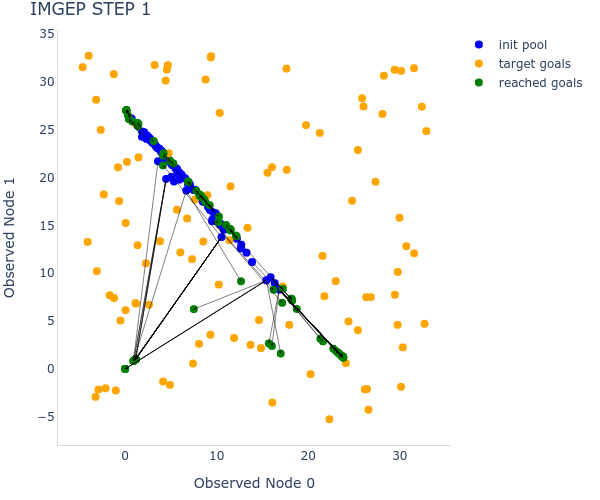

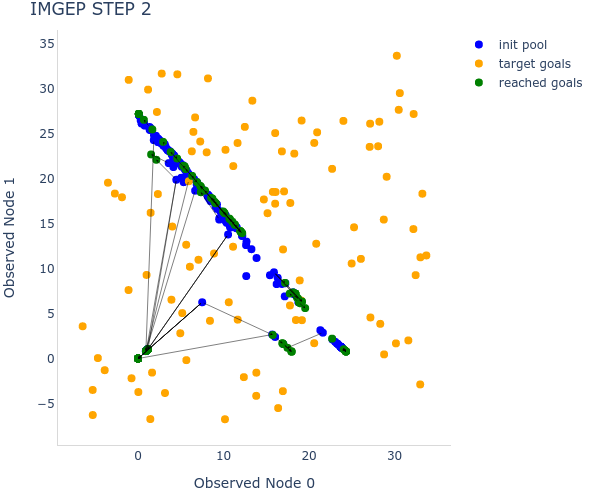

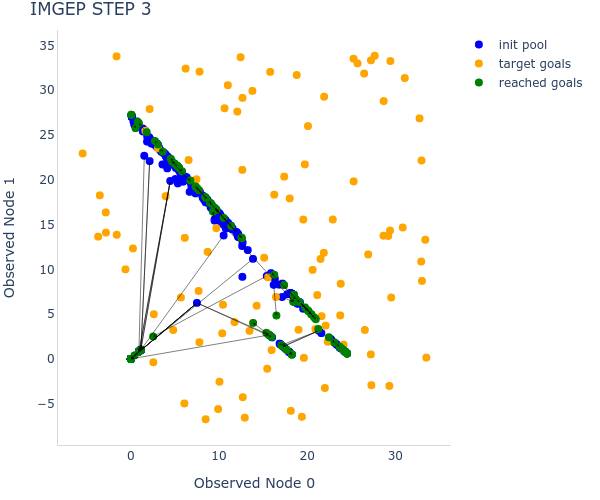

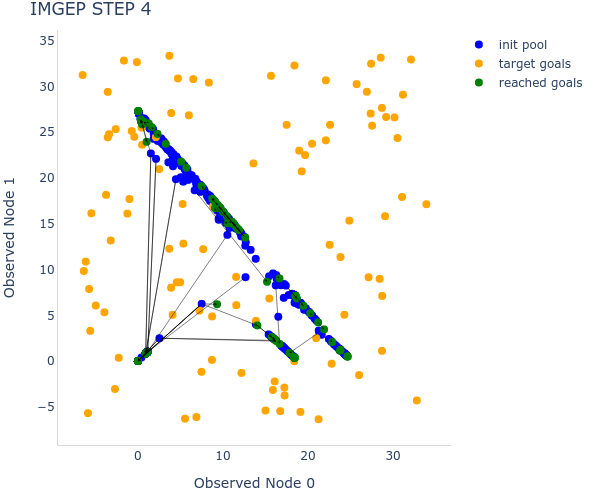

In [5]:
for imgep_step_idx in range(1, n_imgep_steps + 1):

    starting_points = experiment_history.reached_goal_embedding_library[
        : imgep_step_idx * batch_size
    ]
    target_goal_points = experiment_history.target_goal_embedding_library[
        imgep_step_idx * batch_size : (imgep_step_idx + 1) * batch_size
    ]
    selected_starting_points = experiment_history.reached_goal_embedding_library[
        experiment_history.source_intervention_library[
            imgep_step_idx * batch_size : (imgep_step_idx + 1) * batch_size
        ]
    ]
    reached_points = experiment_history.reached_goal_embedding_library[
        imgep_step_idx * batch_size : (imgep_step_idx + 1) * batch_size
    ]

    init_pool = go.Scatter(
        x=starting_points[:, 0],
        y=starting_points[:, 1],
        text=list(range(imgep_step_idx * batch_size)),
        mode="markers",
        marker=dict(color="blue", size=8),
        name="init pool",
    )

    target_goals = go.Scatter(
        x=target_goal_points[:, 0],
        y=target_goal_points[:, 1],
        text=list(
            range(imgep_step_idx * batch_size, (imgep_step_idx + 1) * batch_size)
        ),
        mode="markers",
        marker=dict(color="orange", size=8),
        name="target goals",
    )

    reached_goals = go.Scatter(
        x=reached_points[:, 0],
        y=reached_points[:, 1],
        text=list(
            range(imgep_step_idx * batch_size, (imgep_step_idx + 1) * batch_size)
        ),
        mode="markers",
        marker=dict(color="green", size=8),
        name="reached goals",
    )

    arrows = [
        go.layout.Annotation(
            dict(
                x=x,
                y=y,
                xref="x",
                yref="y",
                text="",
                showarrow=True,
                axref="x",
                ayref="y",
                ax=ax,
                ay=ay,
                arrowhead=3,
                arrowwidth=0.5,
                arrowcolor="black",
            )
        )
        for (x, y, ax, ay) in zip(
            reached_points[:, 0],
            reached_points[:, 1],
            selected_starting_points[:, 0],
            selected_starting_points[:, 1],
        )
    ]

    layout["title"] = f"IMGEP STEP {imgep_step_idx}"
    layout["annotations"] = arrows
    fig = go.Figure(data=[init_pool, target_goals, reached_goals], layout=layout)
    fig.show("png")

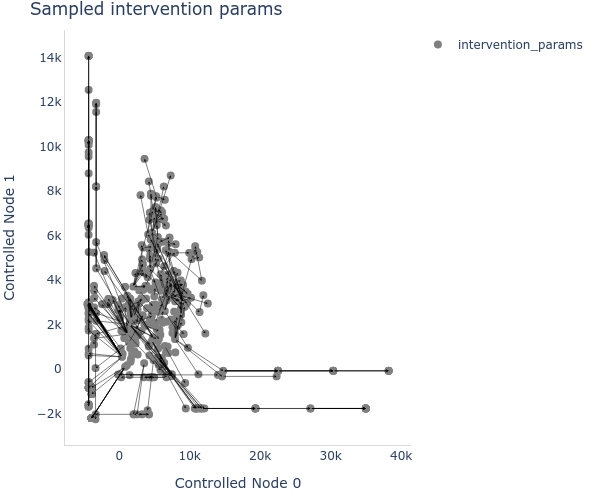

In [6]:
params_x = experiment_history.intervention_params_library.y[0][:, 0]
params_y = experiment_history.intervention_params_library.y[1][:, 0]
selected_params_x = params_x[experiment_history.source_intervention_library]
selected_params_y = params_y[experiment_history.source_intervention_library]
intervention_params = go.Scatter(
    x=params_x,
    y=params_y,
    text=list(range(n_imgep_steps * batch_size)),
    mode="markers",
    marker=dict(color="grey", size=8),
    name="intervention_params",
)

arrows = [
    go.layout.Annotation(
        dict(
            x=x,
            y=y,
            xref="x",
            yref="y",
            text="",
            showarrow=True,
            axref="x",
            ayref="y",
            ax=ax,
            ay=ay,
            arrowhead=3,
            arrowwidth=0.5,
            arrowcolor="black",
        )
    )
    for (x, y, ax, ay) in zip(
        params_x[100:],
        params_y[100:],
        selected_params_x[100:],
        selected_params_y[100:],
    )
]

layout["title"] = "Sampled intervention params"
layout["xaxis"]["title"] = "Controlled Node 0"
layout["yaxis"]["title"] = "Controlled Node 1"
layout["annotations"] = arrows
fig = go.Figure(data=intervention_params, layout=layout)
fig.show("png")

# Evaluate the sampled parameters

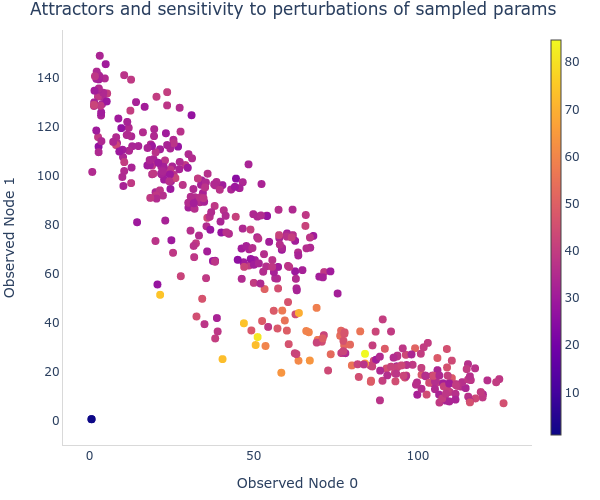

In [7]:
reached_goals_median = jnp.median(
    evaluation_history.reached_goal_embedding_library, axis=1
)
reached_goals_dispersion = jnp.std(
    evaluation_history.reached_goal_embedding_library, axis=1
).mean(axis=-1)

intervention_params = go.Scatter(
    x=reached_goals_median[:, 0],
    y=reached_goals_median[:, 1],
    text=list(range(n_imgep_steps * batch_size)),
    mode="markers",
    marker=dict(color=reached_goals_dispersion, size=8, colorbar=dict(thickness=10)),
)

layout["title"] = "Attractors and sensitivity to perturbations of sampled params"
layout["xaxis"]["title"] = "Observed Node 0"
layout["yaxis"]["title"] = "Observed Node 1"
layout["annotations"] = None
layout["showlegend"] = False
fig = go.Figure(data=intervention_params, layout=layout)
fig.show("png")